In [1]:
%pylab inline
import ROOT
import root_numpy
import pandas as pd
import glob
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyAmsUtils import tree_to_frame

In [133]:
filenames = sorted(glob.glob("/data/13*.root"), key=os.path.getmtime)[:-1]
mcnames = sorted(glob.glob("/data/deuteronMC*.root"), key=os.path.getmtime)

def get_bits_names(f):
    tfile = ROOT.TFile(filenames[0]) 
    return str(tfile.Get("infos/selectionBits").GetString()).split(',')

selBits = get_bits_names(filenames[0])

def get_frame(f, branches=None):
    tfile = ROOT.TFile(f)
    tree  = tfile.Get("selections")
    return tree_to_frame(tree, branches=branches) 

In [131]:
def make_sel_table(data):
    """ Creates rigidity bins and expands bit fields to bool series """
    selTable = {}
    # Binning rigidity
    bins = np.linspace(0,20,101)
    selTable['Rbin'] = pd.cut(data['R'], bins=bins, labels=bins[:-1])
    for i,name  in enumerate(selBits):
        selTable[name] = (data['selStatus'] & (1<<i) ) != 0
    selTable = pd.DataFrame(selTable)

    # Creating agregate vars
    for new in ['minimumbias', 'golden']:
        selTable[new] = True
        for c in selBits: 
            if c.startswith(new): 
                selTable[new] &= selTable[c]
    return selTable

def get_ind_counts(selTable, columns):
    """ Creates counts table"""
    csort = lambda s: s.value_counts().sort_index()
    counts = pd.DataFrame({'Total':csort(selTable['Rbin'])})
    for c in columns:
        counts[c] = csort(selTable['Rbin'][selTable[c]])
    return counts

def sum_counts(filenames):
    counts = None
    for f in filenames:
        print "Processing " + f
        data = get_frame(f, branches=['R', 'selStatus'])
        selTable = make_sel_table(data)
        columns = list(set(selTable.columns) - {'Rbin'})
        if counts is None: 
            counts = get_ind_counts(selTable, columns)
        else:
            counts += get_ind_counts(selTable, columns)
    return counts

# Data

In [134]:
counts = sum_counts(filenames)

Processing /data/1385801337.00000001.ntuple.root
Processing /data/1385802707.00000001.ntuple.root
Processing /data/1385804121.00000001.ntuple.root
Processing /data/1385805491.00000001.ntuple.root
Processing /data/1385806905.00000001.ntuple.root
Processing /data/1385808275.00000001.ntuple.root
Processing /data/1385809689.00000001.ntuple.root
Processing /data/1385811060.00000001.ntuple.root
Processing /data/1385812473.00000001.ntuple.root
Processing /data/1385813843.00000001.ntuple.root
Processing /data/1385815257.00000001.ntuple.root
Processing /data/1385816627.00000001.ntuple.root
Processing /data/1385818041.00000001.ntuple.root
Processing /data/1385819412.00000001.ntuple.root
Processing /data/1385820825.00000001.ntuple.root
Processing /data/1385822195.00000001.ntuple.root
Processing /data/1385823609.00000001.ntuple.root
Processing /data/1385824979.00000001.ntuple.root
Processing /data/1385826578.00000001.ntuple.root
Processing /data/1385827763.00000001.ntuple.root
Processing /data/138

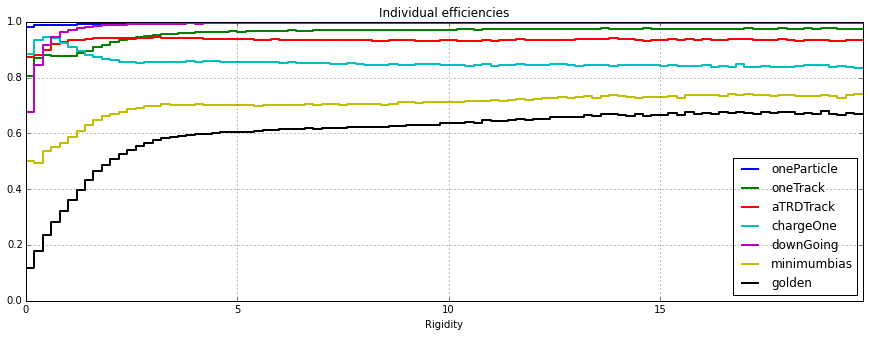

In [135]:
figsize(15,5)
columns = ['oneParticle', 'oneTrack', 'aTRDTrack', 'chargeOne', 'downGoing', 'minimumbias', 'golden']
counts[columns].divide(counts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

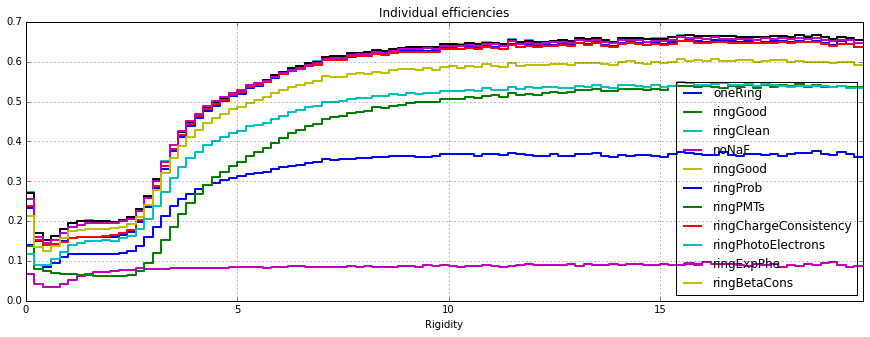

In [136]:
columns = ['oneRing','ringGood', 'ringClean', 'noNaF',
           'ringGood',  'ringProb', 'ringPMTs',
           'ringChargeConsistency', 'ringPhotoElectrons',
           'ringExpPhe', 'ringBetaCons',]
counts[columns].divide(counts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

# D Monte Carlo

In [142]:
mccounts = sum_counts(mcnames)

Processing /data/deuteronMC.ntuple1.root
Processing /data/deuteronMC.ntuple2.root
Processing /data/deuteronMC.ntuple3.root


In [ ]:
figsize(15,5)
columns = ['oneParticle', 'oneTrack', 'aTRDTrack', 'chargeOne', 'downGoing', 'minimumbias', 'golden']
mccounts[columns].divide(mccounts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

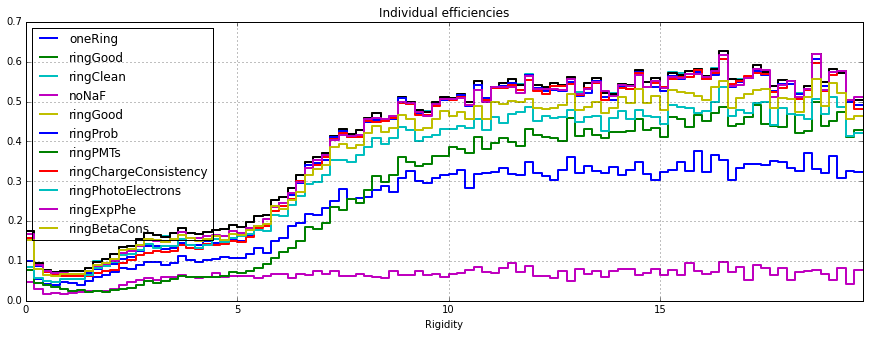

In [144]:
columns = ['oneRing','ringGood', 'ringClean', 'noNaF',
           'ringGood',  'ringProb', 'ringPMTs',
           'ringChargeConsistency', 'ringPhotoElectrons',
           'ringExpPhe', 'ringBetaCons',]
mccounts[columns].divide(mccounts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

# Fraction

In [155]:
effData =   counts.divide(  counts['Total'],axis=0)
effMC   = mccounts.divide(mccounts['Total'],axis=0)
effFr   = (effMC-effData)

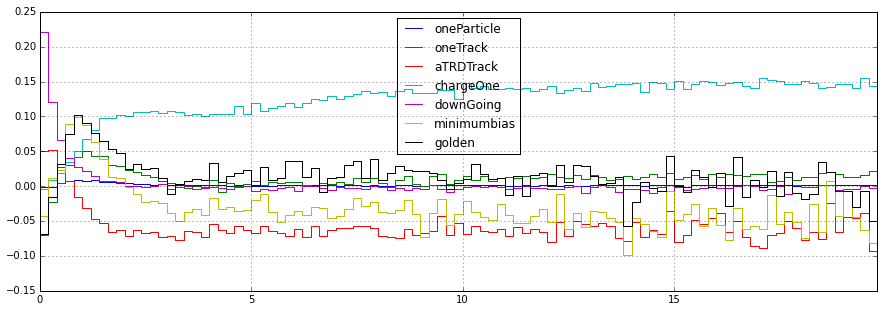

In [156]:
figsize(15,5)
columns = ['oneParticle', 'oneTrack', 'aTRDTrack', 'chargeOne', 'downGoing', 'minimumbias', 'golden']
effFr[columns].plot(drawstyle='steps')

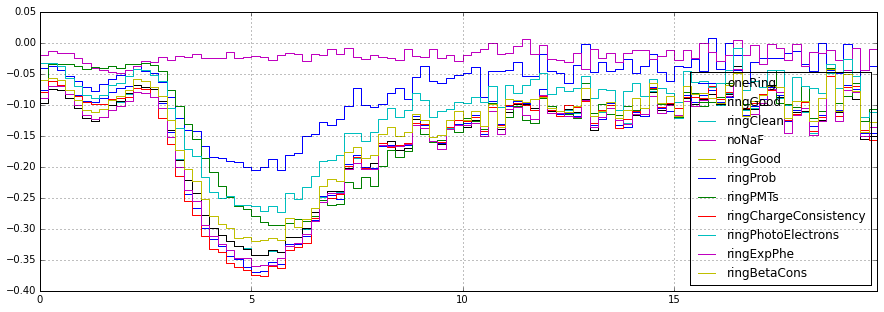

In [157]:
columns = ['oneRing','ringGood', 'ringClean', 'noNaF',
           'ringGood',  'ringProb', 'ringPMTs',
           'ringChargeConsistency', 'ringPhotoElectrons',
           'ringExpPhe', 'ringBetaCons',]
effFr[columns].plot(drawstyle='steps')